In [1]:
import os
from dotenv import load_dotenv
from huggingface_hub import InferenceClient
from langchain_core.prompts import PromptTemplate



d:\Projects\Github_Repo\Multi_Agent_System_Using_Google_ADK\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [13]:
load_dotenv()
HF_TOKEN = os.getenv("HUGGINGFACE_TOKEN")

In [14]:
prompt = PromptTemplate(
    template="""
      You are a helpful assistant.
      

      Question: {question}
    """,
    input_variables = ['question']
)

question= "What is the capital of Brazil?"
final_prompt = prompt.invoke({"question": question}).to_string()

In [15]:

client = InferenceClient()
llm="meta-llama/Llama-3.1-8B-Instruct"
completion = client.chat.completions.create(
    model=llm,
    messages=[
        {"role": "user", "content": final_prompt}
    ]
)

print(completion.choices[0].message.content)

The capital of Brazil is Brasília. Would you like to know more about this city or Brazil in general?


In [16]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict

In [17]:
# define state
class BMIState(TypedDict):

    JD_Description: str
    JD: str

In [18]:
def generate_JD(state: BMIState) -> BMIState:

    JD_Description=state["JD_Description"]
    
    prompt = PromptTemplate(
    template="""
      You are a helpful assistant who can create a Job description based on the given details.
      

      Requirements: {JD_Description}
    """,
    input_variables = ['JD_Description']
    )

    
    final_prompt = prompt.invoke({"JD_Description": JD_Description}).to_string()
    
    client = InferenceClient()
    llm="meta-llama/Llama-3.1-8B-Instruct"
    completion = client.chat.completions.create(
        model=llm,
        messages=[
            {"role": "user", "content": final_prompt}
        ]
    )

    state["JD"]=completion.choices[0].message.content
    

    return state

In [19]:
# define your graph
graph = StateGraph(BMIState)

# add nodes to your graph
graph.add_node('generate_JD', generate_JD)

# add edges to your graph
graph.add_edge(START, 'generate_JD')
graph.add_edge('generate_JD', END)


# compile the graph
workflow = graph.compile()

In [20]:
# execute the graph
intial_state = {'JD_Description':"I need a candidate who has 5+ yeras of experience in AI/ML"}

final_state = workflow.invoke(intial_state)

print(final_state["JD"])

Here's a job description based on the given requirements:

**Job Title:** Artificial Intelligence/ Machine Learning Engineer

**Job Summary:**

We are seeking an experienced AI/ML Engineer to join our team. The ideal candidate will have a strong background in developing and implementing AI and Machine Learning solutions. This is a challenging and rewarding role that requires a unique blend of technical expertise and passion for driving innovation.

**Key Responsibilities:**

* Design, develop, and deploy AI and Machine Learning models to solve complex business problems
* Collaborate with cross-functional teams to identify opportunities for AI and ML implementation
* Develop and maintain large-scale data pipelines and architectures to support AI and ML workflows
* Stay up-to-date with industry trends and advancements in AI and ML, and apply this knowledge to improve our solutions
* Experiment and evaluate new AI and ML algorithms and techniques to optimize performance and accuracy
* Dev

In [11]:
from langchain.tools import tool
import requests

ACCESS_TOKEN = "YOUR_LINKEDIN_ACCESS_TOKEN"
PERSON_URN = "urn:li:person:YOUR_PERSON_ID"

@tool
def post_to_linkedin(text: str) -> str:
    """
    Posts text to LinkedIn on behalf of the user.
    Argument: text (string) - the post content.
    """
    headers = {
        "Authorization": f"Bearer {ACCESS_TOKEN}",
        "Content-Type": "application/json",
        "X-Restli-Protocol-Version": "2.0.0"
    }

    payload = {
        "author": PERSON_URN,
        "lifecycleState": "PUBLISHED",
        "specificContent": {
            "com.linkedin.ugc.ShareContent": {
                "shareCommentary": { "text": text },
                "shareMediaCategory": "NONE"
            }
        },
        "visibility": {
            "com.linkedin.ugc.MemberNetworkVisibility": "PUBLIC"
        }
    }

    url = "https://api.linkedin.com/v2/ugcPosts"
    res = requests.post(url, headers=headers, json=payload)
    return res.text


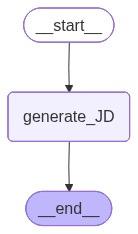

In [12]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())